### Adaptive Filters

In this notebook, we will expand upon our previous Wiener filter notebook and implement the same filter using an adaptive framework. We will use echo-cancelling as the application to demonstrate how to design these adaptive filters.

Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [1]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML('<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.'))

### Echo-Cancellation

Let us consider the following echo-canceller block diagram that we discussed during the lecture. In the following we will simulate a very simplified condition of what happens on the near-end room.

![title](img/echo_canceller.png)

Let us firstly record ourselves speaking, i.e. the signal $v(t)$.



In [14]:
# Recording our speech
T = 3     # recording time (s)
fs = 4000 # sampling freq (Hz)
t = np.arange(0, T, 1/fs)

print ('recording speech ...')
v = sd.rec(T*fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')


recording speech ...
finished recording


Data shape:  (12000, 1)
Recorded Signal:


<IPython.core.display.Javascript object>


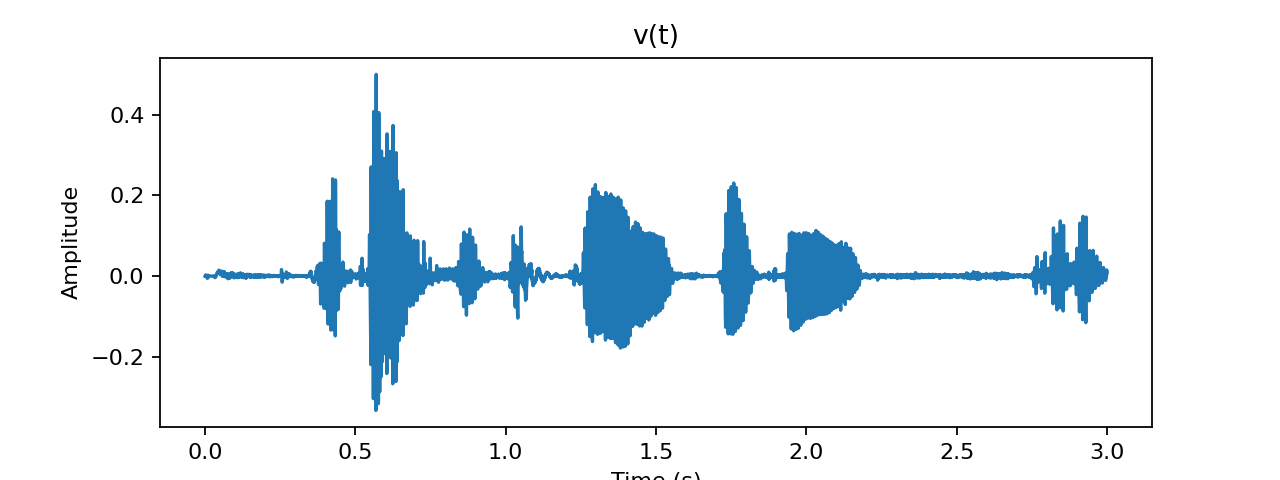

Text(0.5, 1.0, 'v(t)')

In [15]:
# Plotting
print("Data shape: ", v.shape)
print("Recorded Signal:")
IPython.display.display(Audio(v.T, rate=fs,normalize=False))

fig, axes = plt.subplots(figsize=(8, 3)) 

axes.plot(t,v, label = 'Desired')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.set_title('v(t)')

### Propagation through the transmission channel

Okay so we have now recorded our speech with our microphone. Let us assume now that this speech signal has been played through the loudspeaker in the far-end room, then captured by the microphone in the far-end room, and is now finally arriving to the loudspeaker in the near-end room. As an oversimplification, let us represent this process by some fixed delay of D samples. Hence we will simply consider that the signal, $x(t)$ is some delayed version of $v(t)$ (our speech) that was captured by the microphone. 

<IPython.core.display.Javascript object>


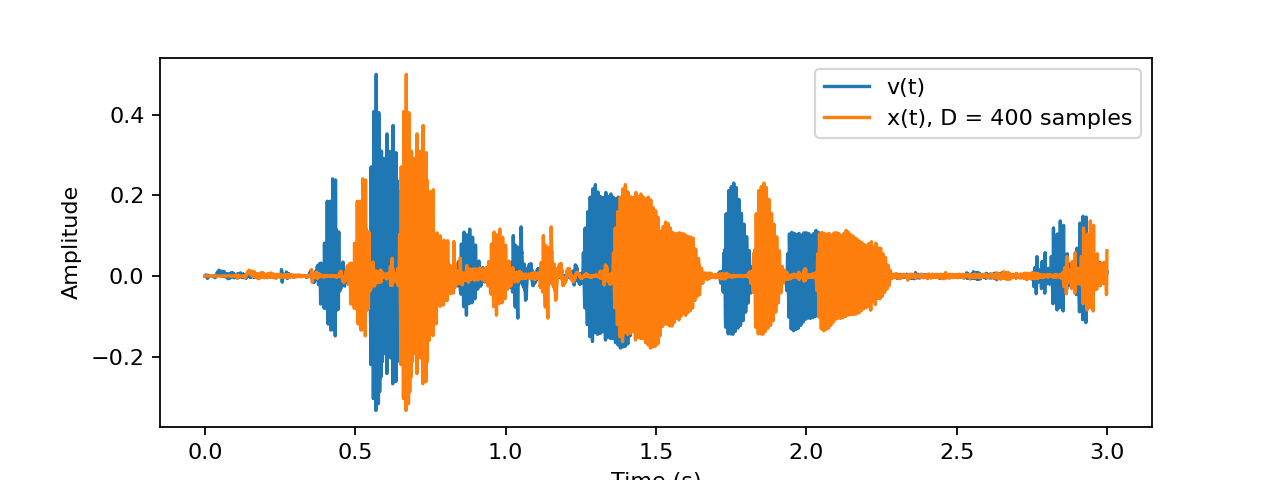

In [16]:
# We apply a delay to our speech signal.

t_delay = 0.1                 # Delay in milli-seconds (ms)
D = int(np.round(t_delay*fs)) # Number of samples of delay.
x = np.roll(v,D) # circular shift of the speech signal we recorded
x[0:D] = 0 # zero out the first D samples.


fig, axes = plt.subplots(figsize=(8, 3)) 

axes.plot(t,v, label = 'v(t)')
axes.plot(t,x, label = 'x(t), D = '+str(D)+' samples')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


### Playing the signal through the loudspeaker

We now have $x(t)$, so let's play this through our loudspeaker and capture it again with our microphone. This now represents the speech signal being filtered by the transmission path between the loudspeaker and the microphone (F). Note that this is not simply a delay as the sound will also be subject to reflections from nearby surfaces. This will now allow us to obtain the signal $u(t)$.

We'll use the 'playrec' function of the sound device package in order to simultaneously playback and record the signal. One important set of parameters for this function is the 'input_mapping' and 'output_mapping'. The input_mapping parameter corresponds to the list of channels used for recording. Since we're only recording with the laptop's microphone, this is set to 1. For the output_mapping, however, if we do not set this parameter, then the signal will be played back through *both* the left and right loudspeaker channels by default. This will create a problem because there would be two transmission paths from each of the loudspeaker channels to the microphone, both of which we will not be able to identify. Hence it is important that we set the output_mapping to 1 or 2, i.e. set it to either  only the left or only the right channel so that there is only one transmission path from the loudspeaker to microphone.

See https://python-sounddevice.readthedocs.io/en/0.4.5/index.html for more info. on sound device package.
Also note that sometimes doing this simultaneous playback and record tends to result in artifacts at times, so you may just have to re-run the cell.

In [17]:
# # You can use the following command to check your audio devices. 
# sd.query_devices()

# Use the playrec function to do simultaneous playback/recording

print ('Playing back x(t) through the loudspeaker and recording...')
u = sd.playrec(data=x, samplerate=fs, input_mapping=[1], output_mapping=[1],blocking=True)
print ('Finished recording')



Playing back x(t) through the loudspeaker and recording...
Finished recording


<IPython.core.display.Javascript object>


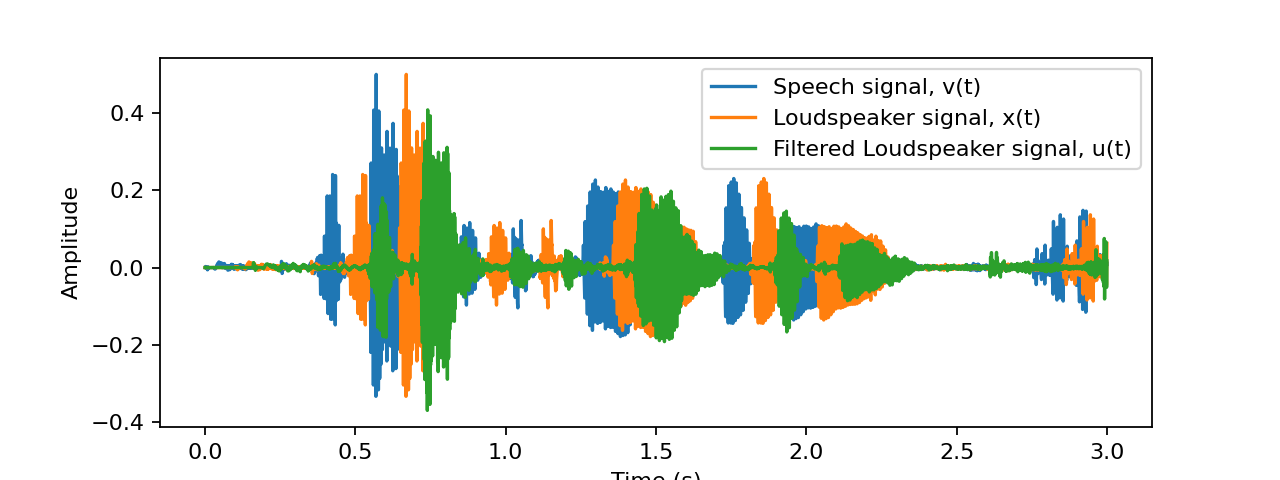

Speech Signal, v(t):


x(t) filtered by Loudspeaker-Mic path, u(t):


<IPython.core.display.Javascript object>


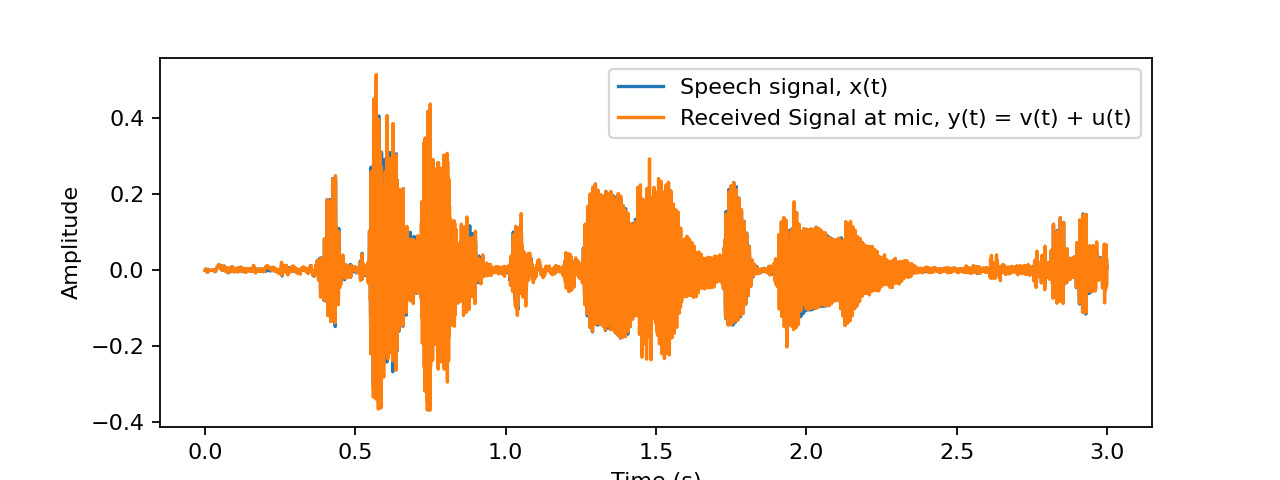

Received Signal at mic, y(t) = v(t) + u(t). Clearly there is an echo!


In [18]:
y_echo = v + u # This is our echo signal that we receive at the microphone

# Plot the signals

fig, axes = plt.subplots(figsize=(8, 3)) 
axes.plot(t,v, label = 'Speech signal, v(t)')
axes.plot(t,x, label = 'Loudspeaker signal, x(t)')
axes.plot(t,u, label = 'Filtered Loudspeaker signal, u(t)')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()

# Let's listen

print("Speech Signal, v(t):")
IPython.display.display(Audio(v.T, rate=fs,normalize=False))

print("x(t) filtered by Loudspeaker-Mic path, u(t):")
IPython.display.display(Audio(u.T, rate=fs,normalize=False))


# Received Mic. Signal

fig, axes = plt.subplots(figsize=(8, 3)) 
axes.plot(t,v, label = 'Speech signal, x(t)')
axes.plot(t,y_echo, label = 'Received Signal at mic, y(t) = v(t) + u(t)')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()

print("Received Signal at mic, y(t) = v(t) + u(t). Clearly there is an echo!")
IPython.display.display(Audio(y_echo.T, rate=fs,normalize=False))


### Estimating the filter from the loudspeaker to the microphone

We have successfully simulated the echo scenario which can occur at the near-end room.
Our goal now is to estimate the filter, F, from the loudspeaker to the microphone. We will then use this to filter $x(t)$ in order to obtain an estimate of the signal $u(t)$. This estimate will be subsequently subtracted from our microphone signal in order to remove the echo. 

To focus on the process of designing the adaptive filters, let us make another simplification. 
Let us assume that $v(t) = 0$, so that $y(t) = u(t)$. Although it seems like an unreasonable assumption, in some specific cases it may not necessarily be such a bad one. For instance if $v(t)$ is a speech signal and the delay between $v(t)$ and $u(t)$ is large enough, then there may be periods of time where only $u(t)$ is active. Certainly we do not expect this to always be the case, so we will also observe the difference in performance if we do not make this assumption.

Firstly proceeding with the assumption that $v(t) = 0$, in Wiener filter terminology, we can now say that $x(t)$ is our input signal and $y(t)$ is our desired signal, both of which are in fact known in this case. So let's try to estimate the filter F in the following ways:

(i) Using a Wiener filter with all the input data

(ii) Using an RLS adaptive filter

(iii) Using an LMS adaptive filter.

#### (i) Wiener Filter

Let's start with the Wiener Filter that we have previously encountered (see the python notebook on Wiener filters for details on the Wiener filter). The optimal Wiener filter will be given as follows:
\begin{equation}
\mathbf{\hat{f}} = \mathbf{R}^{-1}_{xx} \mathbf{r}_{xy},
\end{equation}

where $\mathbf{\hat{f}}$ is estimate of F, i.e. a Wiener filter consisting of P coefficients, $\mathbf{R}_{xx} = \mathbb{E} \{ \mathbf{x x}^{\mathit{T}} \}$ is the autocorrelation matrix of dimension $(P \times P)$, and $\mathbf{r}_{xy} = \mathbb{E} \{ \mathbf{x}y \}$ is the cross-correlation vector of dimension P. The elements of $\mathbf{R}_{xx}$ are given by the autocorrelation function, $r_{xy}(k) = \mathbb{E} \{x(m) x(m+k) \}$ for the m$^{th}$ sample at lag k.

We compute $r_{xx}(k)$ and $r_{xy}(k)$ as follows:

\begin{align}
r_{xx}(k) &= \frac{1}{N} \sum_{m=0}^{N-1} x(m) x(m+k) \\
r_{xy}(k) &= \frac{1}{N} \sum_{m=0}^{N-1} x(m) y(m+k)
\end{align}

These values are then substituted into the equations above to solve for the Wiener filter. 

<IPython.core.display.Javascript object>


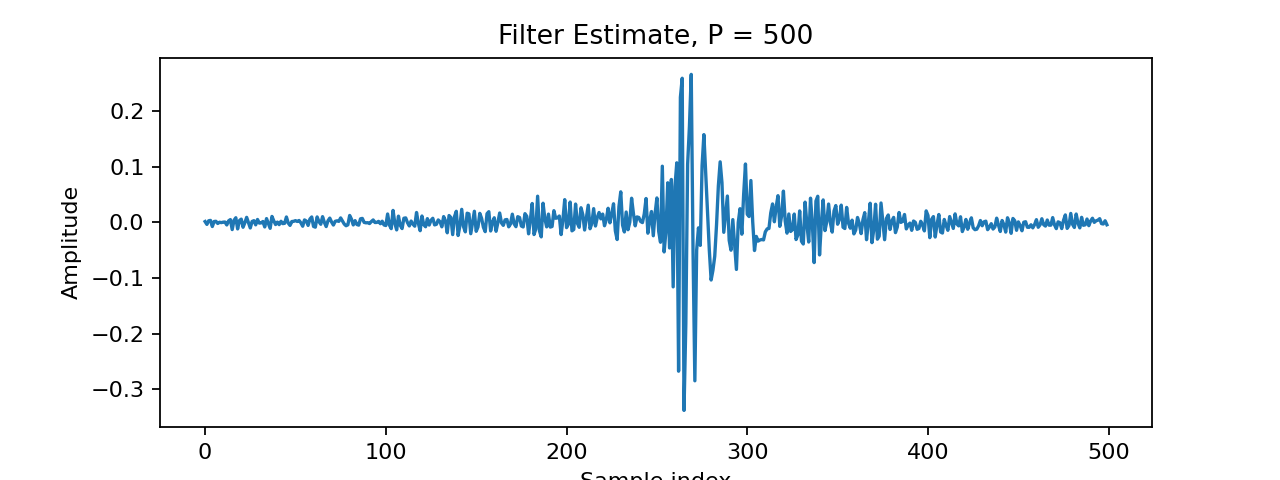

Sample index of peak = 269
Approximate time delay from loudspeaker to recorded mic. signal (includes acoustic and hardware delay) = 0.06725s


In [19]:
# Assumption to set v(t) = 0, hence y = u:
y = u.copy(); v_flag = 0  # Desired signal, set a flag for if v=0 (will use for plotting)

# y = y_echo;  v_flag = 1  # Without assumption that v = 0. 
                           # Uncomment this to observe the effect on the performance
                           # change v_flag = 1, if y = y_echo
N = len(x)

# Select a value for P - number of Wiener filter coefficients
# Depending on how far your loudspeaker is from your microphone (and how much delay your hardware introduces), 
# you may have to increase this number!
P = 500

# The approach to doing the computations of rxx and rxy is as follows.
# For each time lag, k:
#     1. Advance the appropriate signal by lag k - this will be done using a circular shift
#     2. Zero out last k circularly shifted samples
#     3. Then perform the sum as an inner product between the unshifted and shifted version and avg.

rxx = np.zeros([P,1])
rxy = np.zeros([P,1])

for k in range(P):

    y_lag = np.roll(y,-k) # circular shift, note the -k here, it means we are advancing, i.e. (m+k) sample
    x_lag = np.roll(x,-k) 
    
    if k > 0:
        y_lag[-k:] = 0       # zero out last k values
        x_lag[-k:] = 0       
    
        
    rxx[k,0] = (1/N)*x_lag.T@x  # Inner products and average
    rxy[k,0] = (1/N)*y_lag.T@x
    
    
# Create autocorrelation matrix Rxx
row1 = rxx.T  # first row in toeplitz matrix
col1 = rxx # first column in toeplitz matrix
Rxx = sp.linalg.toeplitz(col1, row1)   # Toeplitz matrix

# Solve the system of linear equations
# Use scipy.linalg.solve for solving systems of eqns
f_hat = sp.linalg.solve(Rxx, rxy, assume_a='sym')  # Estimate of echo path from loudspeaker to microphone

# Let's firstly observe what our filter estimate looks like:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(f_hat)
ax.set_xlabel('Sample index')
ax.set_ylabel('Amplitude')
ax.set_title('Filter Estimate, P = '+str(P))

f_hat_max_idx = np.argmax(f_hat) # index where maximum occurs
f_hat_td = f_hat_max_idx/fs # approximate time delay from loudpseaker to microphone

print('Sample index of peak = '+str(f_hat_max_idx))
print('Approximate time delay from loudspeaker to recorded mic. signal (includes acoustic and hardware delay) = '+str(f_hat_td)+ 's')


### Some observations about the estimated filter

The filter that we have estimated is essentially the impulse response from the loudspeaker to the microphone! We can observe that the largest peak of the impulse response occurs at some sample index $> 0$ and is followed by some other smaller peaks. The time at which the largest peak occurs, corresponds to a time delay from the loudspeaker to the captured microphone signal, which includes the time it takes for the signal to physically propagate from the loudspeaker to the microphone plus any hardware delay from your recording device. This time delay can be computed by simply dividing the sample index of the largest peak by the sampling frequency as we did above. In cases where there is close to zero hardware delay from your recording device, this time delay would then correspond only to the time it takes for the signal to physically propagate from the loudspeaker to the microphone. You can in fact do a quick check this by doing the following:

1. Get the sample index of the largest peak
2. Divide this sample index by the sampling frequency to get the time delay in seconds
3. Multiply this time delay by the speed of sound (approx. 343 m/s). 
4. The result you get is a distance in metres. Does this distance correspond to the physical distance between your loudspeaker and microphone? If it is close, it means that your hardware delay is quite small. If not, then there has been quite some hardware delay in acquiring the signal!

In the impulse response, it should also be noted that the smaller peaks after the main peak correspond to reflections from various surfaaces as the signal propagates from the loudspeaker to the microphone. 

Finally, as you probably noticed, the parameter $P$ for the length of the filter is quite important! If this was chosen to be too small, we may not have even been able to estimate the impulse response! Try to re-run the above code with smaller values of P and observe the output. 


### Using the estimated filter to remove the echo

Now that we have estimated the impulse response from the loudspeaker to the microphone (including both the acoustic and electronic contributions), we can use this to filter the signal $x(t)$, which gives us an estimate of the signal $u(t)$. We will call this estimated signal $\hat{u}(t)$. We would expect that $\hat{u}(t)$ will be as close as possible to $u(t)$ in an MSE sense and hence by subtracting $\hat{u}(t)$ from the microphone signal we should (hopefully!) remove the echo.


<IPython.core.display.Javascript object>


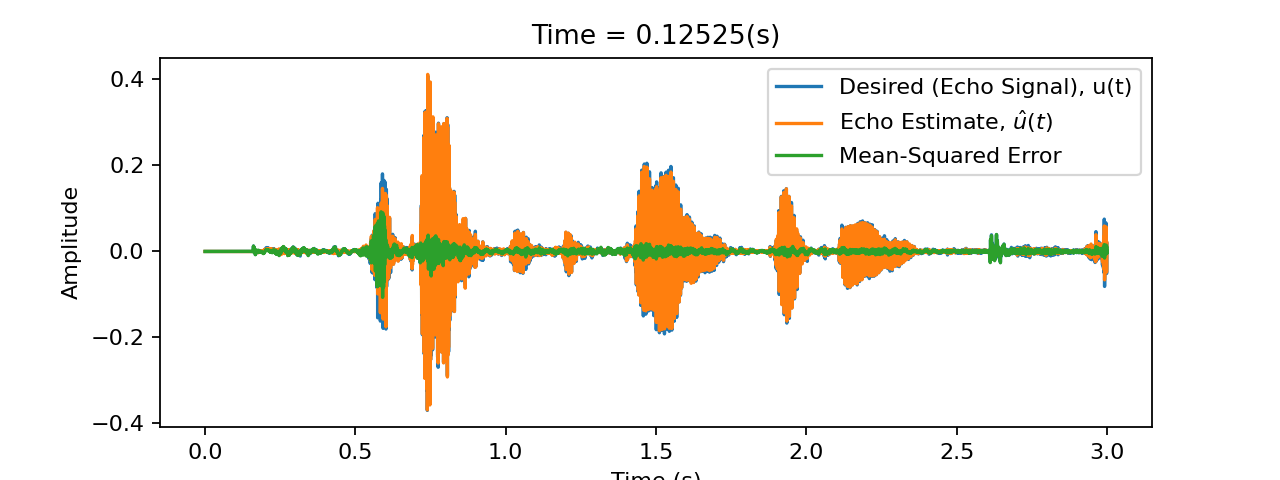

Input, x(t):


Full Echo signal, y(t) = u(t) + v(t):


Echo signal for v(t) = 0, y(t) = u(t):


Echo Estimate, u_hat(t):


Error signal for v(t) = 0; e(t) = u(t) - u_hat(t):


Adding back in v(t); e(t) = u(t) - u_hat(t) + v(t) :


MSE = 4.5735896999422265e-05


In [21]:
# Filter x with this estimate:
# Create toeplitz matrix for X
row1 = np.r_[x[0], np.zeros(P-1)]  # first row in toeplitz matrix
col1 = np.r_[x] # first column in toeplitz matrix
X = sp.linalg.toeplitz(col1, row1)   # Toeplitz matrix
u_hat = X@f_hat   # echo estimate
error = (y-u_hat) # error between the true echo signal and estimate
MSE = (1/N)*np.sum(error**2) # Mean-sqaured error between both signals


if v_flag == 0:
    
    fig, axes = plt.subplots(figsize=(8, 3)) 
    # axes.plot(t,x,label='Input')
    axes.plot(t,y,label='Desired (Echo Signal), u(t)')
    axes.plot(t,u_hat,label='Echo Estimate, $\hat{u}(t)$')
    axes.plot(t,error,label='Error (residual echo)')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amplitude')
    axes.legend()
    
    print("Input, x(t):")
    IPython.display.display(Audio(x.T, rate=fs,normalize=False))
    
    print("Full Echo signal, y(t) = u(t) + v(t):")
    IPython.display.display(Audio(y_echo.T, rate=fs,normalize=False))

    print("Echo signal for v(t) = 0, y(t) = u(t):")
    IPython.display.display(Audio(y.T, rate=fs,normalize=False))

    print("Echo Estimate, u_hat(t):")
    IPython.display.display(Audio(u_hat.T, rate=fs,normalize=False))

    print("Error signal for v(t) = 0; e(t) = u(t) - u_hat(t):")
    IPython.display.display(Audio(error.T, rate=fs,normalize=False))
    
    print("Adding back in v(t); e(t) = u(t) - u_hat(t) + v(t) :")
    IPython.display.display(Audio((error+v).T, rate=fs,normalize=False))

    print("MSE = "+str(MSE))
    
elif v_flag == 1:
    
    fig, axes = plt.subplots(figsize=(8, 3)) 
    axes.plot(t,y,label='Echo Signal (with speech), y(t) = v(t) + u(t)')
    axes.plot(t,u_hat,label='Echo Estimate, $\hat{u}(t)$')
    axes.plot(t,error,label=' Error')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amplitude')
    axes.legend()
    
    print("Input, x(t):")
    IPython.display.display(Audio(x.T, rate=fs,normalize=False))

    print("Full Echo signal, y(t) = u(t) + v(t):")
    IPython.display.display(Audio(y.T, rate=fs,normalize=False))

    print("Echo Estimate, u_hat (t):")
    IPython.display.display(Audio(u_hat.T, rate=fs,normalize=False))

    print("Error signal; e(t) = y(t) - u_hat(t):")
    IPython.display.display(Audio(error.T, rate=fs,normalize=False))

    print("MSE = "+str(MSE))




#### (ii) RLS filter

Cool! So that worked, we were able to successfully model the echo-path F, use it to filter $x(t)$, and cancel the echo. However, with the Wiener filter, we assumed that we had access to all of the data and were able to build the correlation matrix and cross-correlation vector accordingly. This may not always be the case and we may only have a certain number of samples available at a particular time, such as in a real-time scenario. For such cases, we would then need to estimate the filter in an adaptive manner. Let's firstly try the RLS filter. Depending on the value of P, this could take some time. Nevertheless, observe how the filter converges over time (what does it converge to?) and change the forgetting factor, $\lambda$ to see the impact on the convergence.

Recall the algorithm, as it pertains to our notation. $\Phi_{xx} = \mathbf{R_{xx}}^{-1}$

Initialisation: $\Phi_{xx}(0) = \delta \mathbf{I}, \mathbf{{f}}(0) = 0$  
For m = 1, 2, ...  

1. Adaption gain: $\mathbf{k}(m) = \frac{\lambda^{-1} \Phi_{xx}(m-1) \mathbf{x}(m)}{1 + \lambda^{-1} \mathbf{x}^{T}(m)\Phi_{xx}(m-1) \mathbf{x}(m)}$   


2. Error signal: $e(m) = y(m) - \mathbf{f}^{T}(m-1) \mathbf{x}(m)$  


3. Filter coefficient update: $\mathbf{f}(m) = \mathbf{f}(m-1) + \mathbf{k}e(m) $   


4. Inverse autocorr. matrix update: $\Phi_{xx}(m) = \lambda^{-1} \Phi_{xx}(m-1) + \lambda^{-1} \mathbf{x}^{T}(m)\Phi_{xx}(m-1)$


In [22]:
# Initialistion:

delta = 1e-5
Phi_xx = delta*np.eye(P)
f_rls = np.zeros([P,len(x)]) # will keep track of all the filters over time
lambda_ff = 0.995 # Forgetting factor - Change this to observe how the filter converges.
uhat_rls = np.zeros([len(x),1])
e_rls = np.zeros([len(x),1])


# We start the for loop from P+1 so that we have enough previous samples m-(P-1).
# We could also start from m = 1, and then set initial values of x(m) for m < 0 equal to zero.
# Since x has a delay already in it, it will not make much of a difference.

for m in np.arange(P+1,len(x),1): 
    
    if (m%2000) == 0:
        print('Processing sample '+str(m)+ ' out of '+str(len(x)))
        
    # P samples in x
    x_tmp = x[m-(P-1):m+1] # We need the m+1 here because of python's convention to select values up to the last index-1
    x_P = x_tmp[::-1] # reverse the columns so x(m) is the first element
    
    # 1. Compute the adaptation gain
    k_num = (1/lambda_ff)*(Phi_xx@x_P)  # This is the previous Phi_xx at (m-1), but current x(m)
    k_den = 1 + (1/lambda_ff)*(x_P.T@Phi_xx@x_P)
    k_gain = k_num/k_den
    
    # 2. Error signal
    uhat_rls[m] = (f_rls[:,m-1].T)@x_P # this will be our filtered signal
    e_rls[m] = y[m] -  uhat_rls[m]
    
    # 3. Update filter coefficients
    f_rls[:,m] = f_rls[:,m-1] + k_gain@e_rls[m]

    # 4. Update the Inverse autocorrelation matrix
    Phi_xx = (1/lambda_ff)*(Phi_xx) - (1/lambda_ff)*(k_gain@x_P.T@Phi_xx)
    
print('Finished!')    


Processing sample 2000 out of 12000
Processing sample 4000 out of 12000
Processing sample 6000 out of 12000
Processing sample 8000 out of 12000
Processing sample 10000 out of 12000
Finished!


<IPython.core.display.Javascript object>


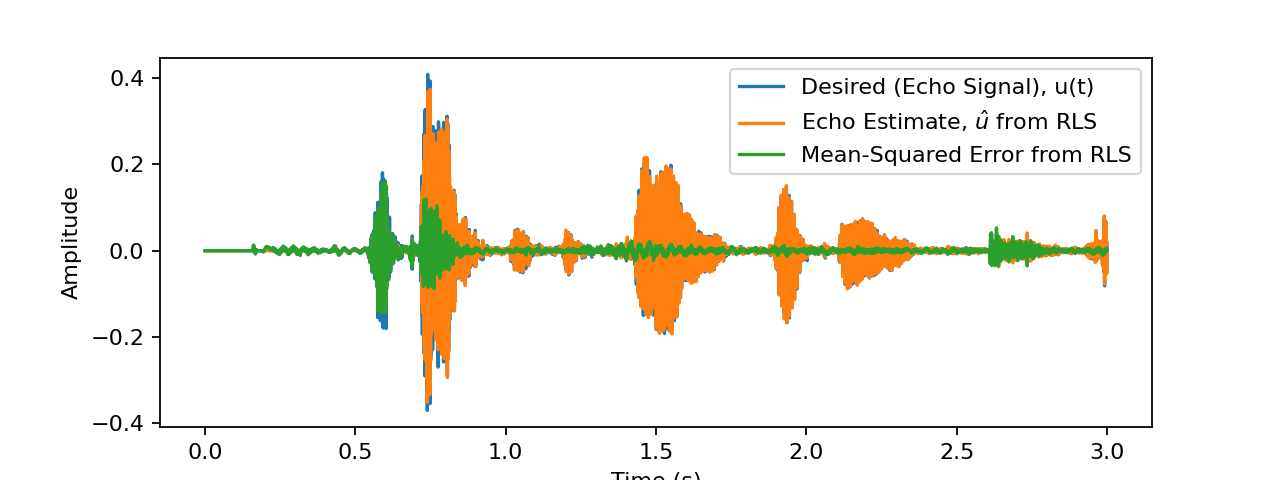

<IPython.core.display.Javascript object>


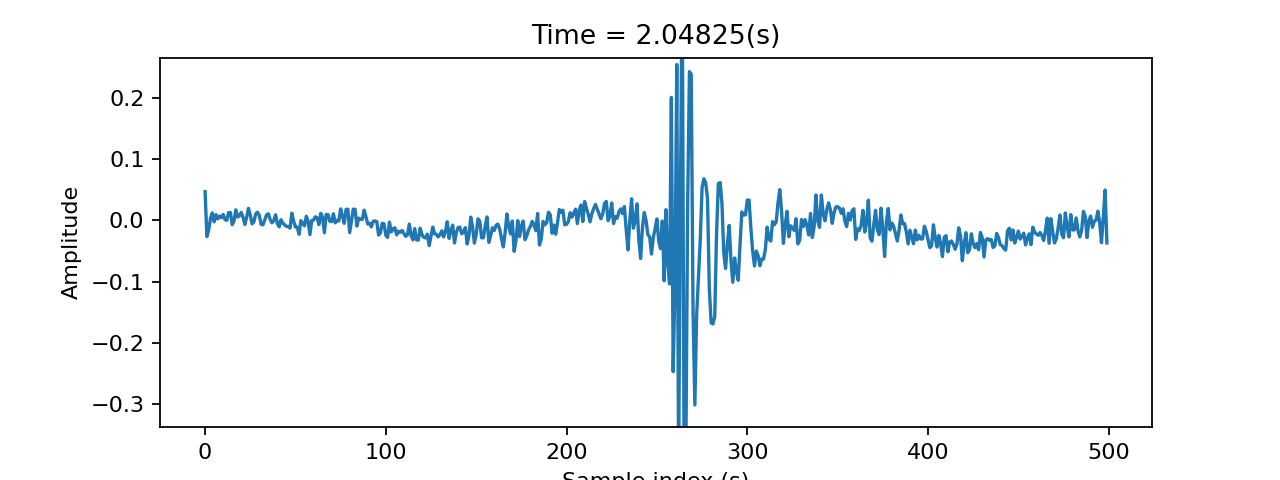

Move the slider to see how the filter converges with time! (m is the sample index).


interactive(children=(IntSlider(value=501, description='m', max=11999, min=501), Output()), _dom_classes=('wid…

Input, x(t):


Full Echo signal, y(t) = u(t) + v(t):


Echo signal for v(t) = 0, y(t) = u(t):


Echo Estimate, u_hat(t) using RLS:


RLS Error signal for v(t) = 0; e(t) = u(t) - u_hat(t):


Adding back in v(t); e(t) = u(t) - u_hat(t) + v(t) :


MSE from Wiener Filter= 4.5735896999422265e-05
MSE from RLS= 0.0001283150029243497


In [23]:
# Let's plot the results to see what that gave us... (hope for the best...)
MSE_rls = (1/N)*np.sum(e_rls**2) # Mean-sqaured error between both signals

if v_flag == 0:

    # Plotting
    
    fig, axes = plt.subplots(figsize=(8, 3)) 
    axes.plot(t,y,label='Desired (Echo Signal), u(t)')
    axes.plot(t,uhat_rls,label='Echo Estimate, $\hat{u}$ from RLS')
    axes.plot(t,e_rls,label='Mean-Squared Error from RLS')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amplitude')
    axes.legend()
    
#   Interactive plot to view convergence of filter
    fig, axes = plt.subplots(figsize=(8, 3)) 
    line, = axes.plot(f_rls[:,P+1])
    axes.set_xlabel('Sample index (s)')
    axes.set_ylabel('Amplitude')
    axes.set_ylim([np.min(f_hat), np.max(f_hat)])
    
    def update(m = 0):
        line.set_ydata(f_rls[:,m])
        axes.set_title('Time = '+str(m/fs)+ '(s)')

    print('Move the slider to see how the filter converges with time! (m is the sample index).')
    interact(update, m = (P+1,len(x)-1,1));  

    
    # Listening
    
    print("Input, x(t):")
    IPython.display.display(Audio(x.T, rate=fs,normalize=False))
    
    print("Full Echo signal, y(t) = u(t) + v(t):")
    IPython.display.display(Audio(y_echo.T, rate=fs,normalize=False))

    print("Echo signal for v(t) = 0, y(t) = u(t):")
    IPython.display.display(Audio(y.T, rate=fs,normalize=False))

    print("Echo Estimate, u_hat(t) using RLS:")
    IPython.display.display(Audio(uhat_rls.T, rate=fs,normalize=False))

    print("RLS Error signal for v(t) = 0; e(t) = u(t) - u_hat(t):")
    IPython.display.display(Audio(e_rls.T, rate=fs,normalize=False))
    
    print("Adding back in v(t); e(t) = u(t) - u_hat(t) + v(t) :")
    IPython.display.display(Audio((e_rls+v).T, rate=fs,normalize=False))    

    print("MSE from Wiener Filter= "+str(MSE))
    print("MSE from RLS= "+str(MSE_rls))

elif v_flag == 1:
    
    fig, axes = plt.subplots(figsize=(8, 3)) 
    axes.plot(t,y,label='Echo Signal (with speech), y(t) = v(t) + u(t)')
    axes.plot(t,uhat_rls,label='Echo Estimate, $\hat{u}(t)$')
    axes.plot(t,e_rls,label='Mean-Squared Error')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amplitude')
    axes.legend()
    
    #   Interactive plot to view convergence of filter
    fig, axes = plt.subplots(figsize=(8, 3)) 
    line, = axes.plot(f_rls[:,P+1])
    axes.set_xlabel('Sample index (s)')
    axes.set_ylabel('Amplitude')
    axes.set_ylim([np.min(f_hat), np.max(f_hat)])
    
    def update(m = 0):
        line.set_ydata(f_rls[:,m])
        axes.set_title('Time = '+str(m/fs)+ '(s)')

    print('Move the slider to see how the filter converges with time! (m is the sample index)')
    interact(update, m = (P+1,len(x)-1,1));  
    
    print("Input, x(t):")
    IPython.display.display(Audio(x.T, rate=fs,normalize=False))

    print("Full Echo signal, y(t) = u(t) + v(t):")
    IPython.display.display(Audio(y.T, rate=fs,normalize=False))

    print("Echo Estimate, u_hat (t):")
    IPython.display.display(Audio(uhat_rls.T, rate=fs,normalize=False))

    print("Error signal; e(t) = y(t) - u_hat(t):")
    IPython.display.display(Audio(e_rls.T, rate=fs,normalize=False))

    print("MSE from Wiener Filter= "+str(MSE))
    print("MSE from RLS= "+str(MSE_rls))




#### (iii) LMS filter

So that also worked! I hope you messed around with the forgetting factor to see the effect of it. 
Alright, so let's implement the final filter - the least mean squares (LMS) filter, which should be some P times faster than the RLS. Once again, observe how the filter converges over time and change the step size, $\mu$ to see the impact on the convergence. It's interesting to note how accurate to the Wiener filter estimate we need to be in order to get audibly pleasing results. 

Recall the algorithm, as it pertains to our notation.

Initialisation: Set a value for step size $\mu$, $\mathbf{{f}}(0) = 0$  
For m = 0, 1, 2, ...  
  
1. Error signal with old filter: $e(m) = y(m) - \mathbf{f}^{T}(m) \mathbf{x}(m)$   


2. Filter coefficient update: $\mathbf{f}(m+1) = \mathbf{f}(m) + \mu \mathbf{x}(m)e(m) $   


3. Update Error signal with new filter: $e(m) = y(m) - \mathbf{f}^{T}(m+1) \mathbf{x}(m)$


In [24]:
# Initialisation

mu = 0.2 # Step size - change the value of this to see the effect
f_lms = np.zeros([P,len(x)])
uhat_lms = np.zeros([len(x),1])
e_lms = np.zeros([len(x),1])


# We start the for loop from P+1 so that we have enough previous samples m-(P-1).
# We could also start from m = 1, and then set initial values of x(m) for m < 0 equal to zero.
# Since x has a delay already in it, it will not make much of a difference.

for m in np.arange(P+1,len(x)-1,1): 
    
    # P samples in x
    x_tmp = x[m-(P-1):m+1] # We need the m+1 here because of python's convention to select values up to the last index-1
    x_P = x_tmp[::-1] # reverse the columns so x(m) is the first element
    
    # 1. Error signal with old filter
    e_old = y[m] -  (f_lms[:,m].T)@x_P 
    
    # 2. Update filter coefficients
    f_lms[:,m+1] = f_lms[:,m] + mu*(x_P@e_old)

    # 3. Update the error signal with new updated filter
    uhat_lms[m] = (f_lms[:,m+1].T)@x_P 
    e_lms[m] = y[m] - uhat_lms[m]
    
    

<IPython.core.display.Javascript object>


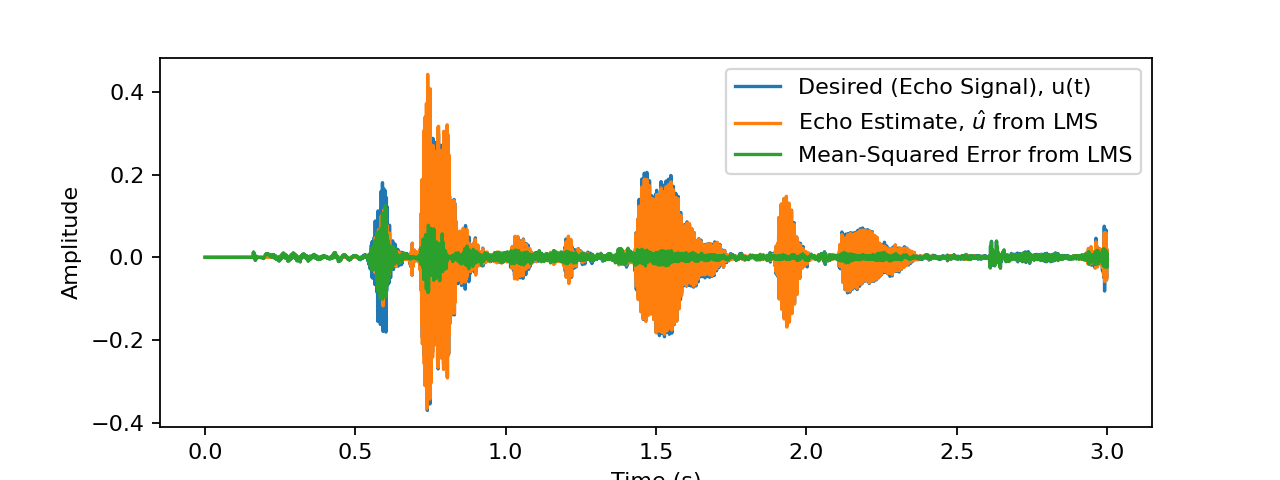

<IPython.core.display.Javascript object>


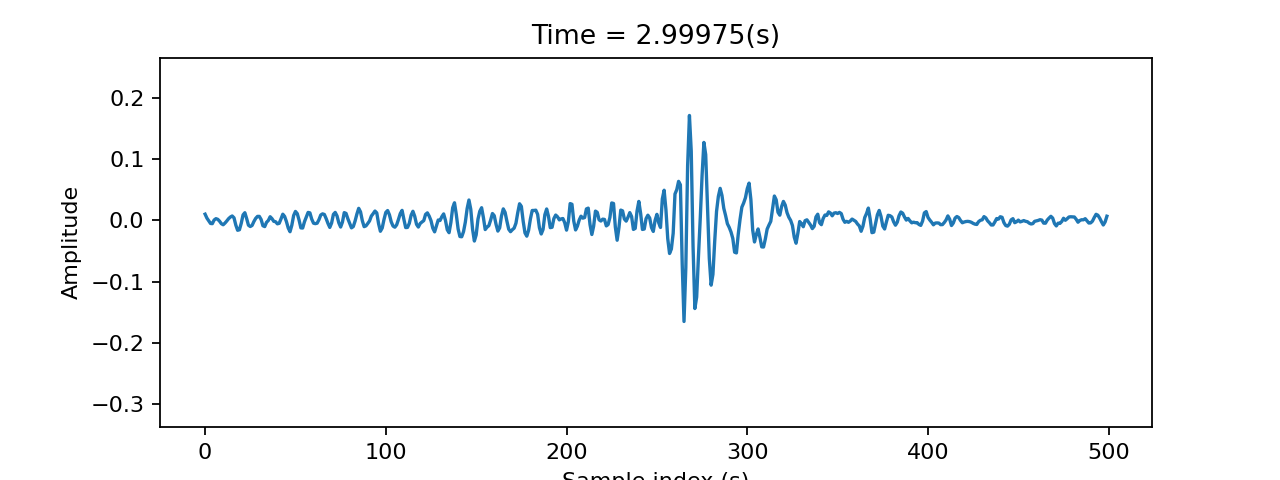

Move the slider to see how the filter converges with time! (m is the sample index).


interactive(children=(IntSlider(value=501, description='m', max=11999, min=501), Output()), _dom_classes=('wid…

Input, x(t):


Full Echo signal, y(t) = u(t) + v(t):


Echo signal for v(t) = 0, y(t) = u(t):


Echo Estimate, u_hat(t) using LMS:


LMS Error signal for v(t) = 0; e(t) = u(t) - u_hat(t):


Adding back in v(t); e(t) = u(t) - u_hat(t) + v(t) :


MSE from Wiener Filter= 4.5735896999422265e-05
MSE from RLS= 0.0001283150029243497
MSE from LMS= 6.34689558625026e-05


In [25]:
# Plotting results
MSE_lms = (1/N)*np.sum(e_lms**2) # Mean-sqaured error between both signals


if v_flag == 0:

    # Plotting
    
    fig, axes = plt.subplots(figsize=(8, 3)) 
    axes.plot(t,y,label='Desired (Echo Signal), u(t)')
    axes.plot(t,uhat_lms,label='Echo Estimate, $\hat{u}$ from LMS')
    axes.plot(t,e_lms,label='Mean-Squared Error from LMS')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amplitude')
    axes.legend()
    
#   Interactive plot to view convergence of filter
    fig, axes = plt.subplots(figsize=(8, 3)) 
    line, = axes.plot(f_lms[:,P+1])
    axes.set_xlabel('Sample index (s)')
    axes.set_ylabel('Amplitude')
    axes.set_ylim([np.min(f_hat), np.max(f_hat)])
    
    def update(m = 0):
        line.set_ydata(f_lms[:,m])
        axes.set_title('Time = '+str(m/fs)+ '(s)')

    print('Move the slider to see how the filter converges with time! (m is the sample index).')
    interact(update, m = (P+1,len(x)-1,1));  

    
    # Listening
    
    print("Input, x(t):")
    IPython.display.display(Audio(x.T, rate=fs,normalize=False))
    
    print("Full Echo signal, y(t) = u(t) + v(t):")
    IPython.display.display(Audio(y_echo.T, rate=fs,normalize=False))

    print("Echo signal for v(t) = 0, y(t) = u(t):")
    IPython.display.display(Audio(y.T, rate=fs,normalize=False))

    print("Echo Estimate, u_hat(t) using LMS:")
    IPython.display.display(Audio(uhat_lms.T, rate=fs,normalize=False))

    print("LMS Error signal for v(t) = 0; e(t) = u(t) - u_hat(t):")
    IPython.display.display(Audio(e_lms.T, rate=fs,normalize=False))
    
    print("Adding back in v(t); e(t) = u(t) - u_hat(t) + v(t) :")
    IPython.display.display(Audio((e_lms+v).T, rate=fs,normalize=False))    

    print("MSE from Wiener Filter= "+str(MSE))
    print("MSE from RLS= "+str(MSE_rls))
    print("MSE from LMS= "+str(MSE_lms))

elif v_flag == 1:
    
    fig, axes = plt.subplots(figsize=(8, 3)) 
    axes.plot(t,y,label='Echo Signal (with speech), y(t) = v(t) + u(t)')
    axes.plot(t,uhat_lms,label='Echo Estimate, $\hat{u}(t)$')
    axes.plot(t,e_lms,label='Mean-Squared Error')
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Amplitude')
    axes.legend()
    
    #   Interactive plot to view convergence of filter
    fig, axes = plt.subplots(figsize=(8, 3)) 
    line, = axes.plot(f_lms[:,P+1])
    axes.set_xlabel('Sample index (s)')
    axes.set_ylabel('Amplitude')
    axes.set_ylim([np.min(f_hat), np.max(f_hat)])
    
    def update(m = 0):
        line.set_ydata(f_lms[:,m])
        axes.set_title('Time = '+str(m/fs)+ '(s)')

    print('Move the slider to see how the filter converges with time! (m is the sample index)')
    interact(update, m = (P+1,len(x)-1,1));  
    
    print("Input, x(t):")
    IPython.display.display(Audio(x.T, rate=fs,normalize=False))

    print("Full Echo signal, y(t) = u(t) + v(t):")
    IPython.display.display(Audio(y.T, rate=fs,normalize=False))

    print("Echo Estimate, u_hat (t):")
    IPython.display.display(Audio(uhat_lms.T, rate=fs,normalize=False))

    print("Error signal; e(t) = y(t) - u_hat(t):")
    IPython.display.display(Audio(e_lms.T, rate=fs,normalize=False))

    print("MSE from Wiener Filter= "+str(MSE))
    print("MSE from RLS= "+str(MSE_rls))
    print("MSE from LMS= "+str(MSE_lms))



### Confronting the assumptions

Okay so that's the end of this echo-canceller demo. At this stage we should have a better appreciation of the Wiener filter and its adaptive counter parts, and the tuning parameters to make it all work well. We should also reflect on the assumptions we have made up to this point, namely that $v(t) = 0$. It is recommended to re-run the above codes, but now do not set $v(t) = 0$. Alternatively, let $y(t) = u(t) + v(t)$. How does the performance change? How can we improve things from here on... Much of the literature on echo-cancellation addresses such issues. 
